In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.6/922.6 kB 16.1 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Train videos: 240
Validation videos: 80
Test videos: 80


100%|██████████| 6.25M/6.25M [00:00<00:00, 79.9MB/s]
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 90.3MB/s]


Training model from scratch for 30 epochs...
Epoch 1/30: Train Loss 0.7006, Train Acc 47.08% | Val Loss 0.6736, Val Acc 65.00%
Epoch 2/30: Train Loss 0.6715, Train Acc 62.50% | Val Loss 0.6382, Val Acc 66.25%
Epoch 3/30: Train Loss 0.6032, Train Acc 73.33% | Val Loss 0.5084, Val Acc 81.25%
Epoch 4/30: Train Loss 0.4550, Train Acc 82.50% | Val Loss 0.3368, Val Acc 88.75%
Epoch 5/30: Train Loss 0.3172, Train Acc 87.92% | Val Loss 0.2973, Val Acc 91.25%
Epoch 6/30: Train Loss 0.3137, Train Acc 87.92% | Val Loss 0.3076, Val Acc 91.25%
Epoch 7/30: Train Loss 0.3643, Train Acc 87.08% | Val Loss 0.2890, Val Acc 91.25%
Epoch 8/30: Train Loss 0.3705, Train Acc 84.58% | Val Loss 0.2858, Val Acc 91.25%
Epoch 9/30: Train Loss 0.4174, Train Acc 80.42% | Val Loss 0.3260, Val Acc 91.25%
Epoch 10/30: Train Loss 0.3301, Train Acc 85.42% | Val Loss 0.3078, Val Acc 91.25%
Epoch 11/30: Train Loss 0.2948, Train Acc 89.58% | Val Loss 0.3381, Val Acc 91.25%
Epoch 12/30: Train Loss 0.2760, Train Acc 88.75% | 

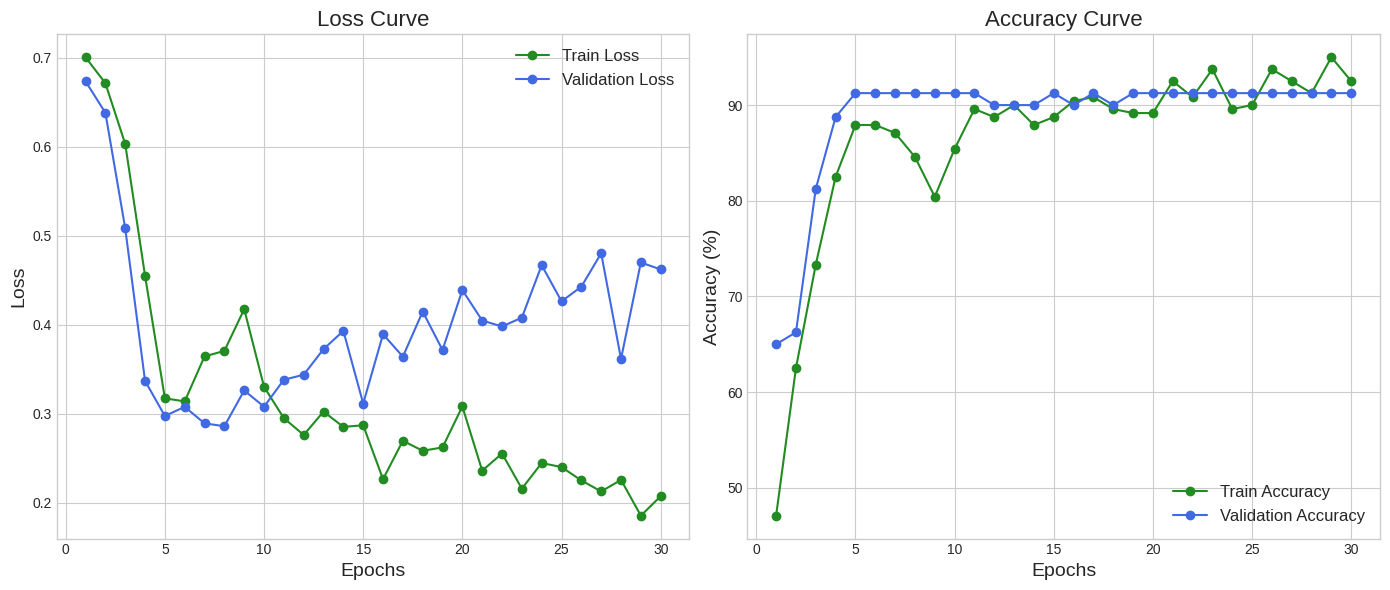

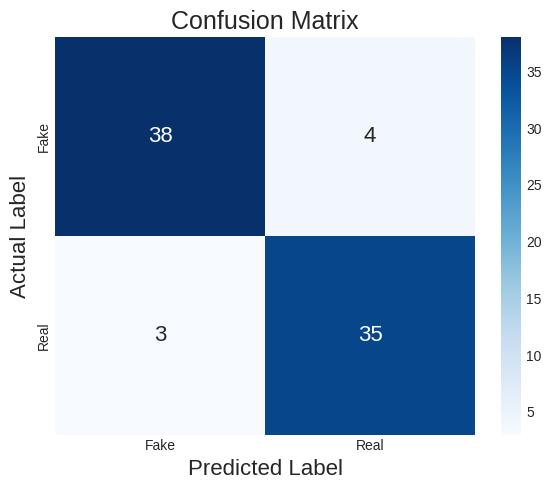

Calculated Accuracy from Confusion Matrix: 91.25%


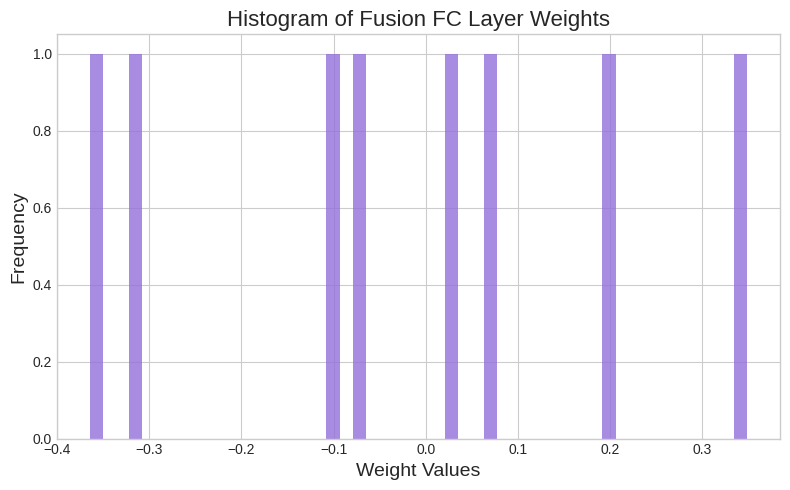

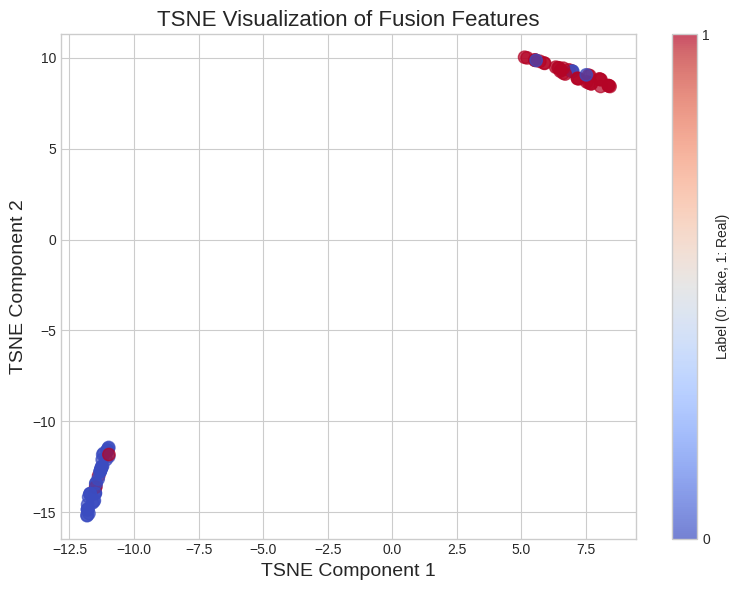

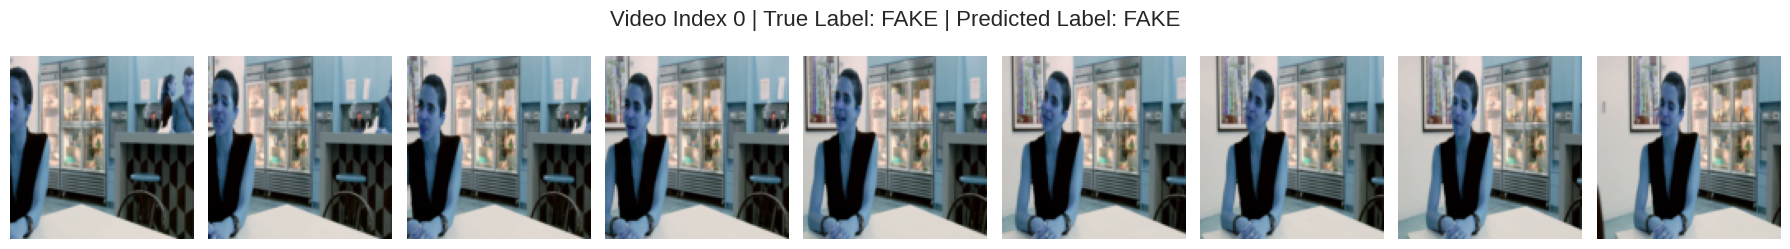

In [2]:
import os
import glob
import random
import numpy as np
import cv2
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from ultralytics import YOLO  # YOLOv8 from ultralytics

# Use the recommended matplotlib style for a neat look.
plt.style.use('seaborn-v0_8-whitegrid')

#############################################
# 1. Data Loading and Preprocessing
#############################################
# Define directories for videos on Kaggle (update these paths if needed)
REAL_VIDEOS_DIR = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
FAKE_VIDEOS_DIR = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"

# Use 200 videos per class
real_videos = sorted(glob.glob(os.path.join(REAL_VIDEOS_DIR, '*.mp4')))[:200]
fake_videos = sorted(glob.glob(os.path.join(FAKE_VIDEOS_DIR, '*.mp4')))[:200]

video_files = real_videos + fake_videos
labels = [1] * len(real_videos) + [0] * len(fake_videos)
combined = list(zip(video_files, labels))
random.shuffle(combined)
video_files, labels = zip(*combined)
video_files = list(video_files)
labels = list(labels)

# Split into train (60%), validation (20%), and test (20%) sets.
total_samples = len(video_files)
train_end = int(0.6 * total_samples)
val_end = int(0.8 * total_samples)
train_videos = video_files[:train_end]
train_labels = labels[:train_end]
valid_videos = video_files[train_end:val_end]
valid_labels = labels[train_end:val_end]
test_videos = video_files[val_end:]
test_labels = labels[val_end:]

print("Train videos:", len(train_videos))
print("Validation videos:", len(valid_videos))
print("Test videos:", len(test_videos))

#############################################
# Image Transformations
#############################################
im_size = 112
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
basic_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#############################################
# 2. Dataset Class (Extract 90 frames per video)
#############################################
class VideoDataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=90, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        cap = cv2.VideoCapture(video_path)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            if len(frames) == self.seq_len:
                break
        cap.release()
        # If video has fewer than required frames, duplicate the last frame.
        if len(frames) < self.seq_len:
            while len(frames) < self.seq_len:
                frames.append(frames[-1])
        frames = torch.stack(frames)  # shape: [seq_len, 3, 112, 112]
        return frames, self.labels[idx]

train_dataset = VideoDataset(train_videos, train_labels, sequence_length=90, transform=basic_transforms)
valid_dataset = VideoDataset(valid_videos, valid_labels, sequence_length=90, transform=basic_transforms)
test_dataset  = VideoDataset(test_videos, test_labels, sequence_length=90, transform=basic_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

#############################################
# 3. YOLOv8-based Face Extraction Helper
#############################################
# Load YOLOv8 model (nano version for speed)
yolo_model = YOLO('yolov8n.pt')

def extract_face(frame_tensor):
    """
    Denormalize frame_tensor ([3,112,112]), convert to NumPy image,
    run YOLOv8 to detect a 'person' (COCO class 0), and return a face crop resized to 112x112.
    """
    frame_np = frame_tensor.cpu().numpy().transpose(1, 2, 0)
    frame_np = (frame_np * np.array(std) + np.array(mean)) * 255.0
    frame_np = np.clip(frame_np, 0, 255).astype(np.uint8)
    frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
    results = yolo_model(frame_bgr , verbose=False)
    boxes = results[0].boxes
    H, W, _ = frame_bgr.shape
    best_box = None
    best_conf = 0
    for box in boxes:
        cls = int(box.cls.item())
        conf = box.conf.item()
        if cls == 0 and conf > best_conf:
            best_conf = conf
            best_box = box.xyxy[0].tolist()
    if best_box is not None:
        xmin, ymin, xmax, ymax = map(int, best_box)
        face_crop = frame_bgr[ymin:ymax, xmin:xmax]
        if face_crop.size == 0:
            face_crop = frame_bgr[H//4:3*H//4, W//4:3*W//4]
    else:
        face_crop = frame_bgr[H//4:3*H//4, W//4:3*W//4]
    face_crop = cv2.resize(face_crop, (112, 112))
    face_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
    face_crop_tensor = transforms.ToTensor()(face_crop)
    return face_crop_tensor.to(frame_tensor.device)

#############################################
# 4. GAN-inspired Discriminator Branch
#############################################
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, 128)
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#############################################
# 5. Hybrid Model Definition with Optional Feature Return
#############################################
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

class HybridModel(nn.Module):
    def __init__(self, num_classes, bidirectional=False):
        super(HybridModel, self).__init__()
        # Branch 1: ResNeXt50 + LSTM branch
        weights = ResNeXt50_32X4D_Weights.IMAGENET1K_V1
        backbone = models.resnext50_32x4d(weights=weights)
        self.cnn_backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(2048, 2048, 1, bidirectional=bidirectional)
        self.fc_branch1 = nn.Linear(2048, num_classes)
        
        # Branch 2: Face-based branch
        self.face_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.discriminator = SimpleDiscriminator()
        self.fc_branch2 = nn.Linear(192, num_classes)  # 64 + 128 = 192
        
        # Fusion layer: fuse outputs from both branches.
        self.fusion_fc = nn.Linear(num_classes * 2, num_classes)
    
    def forward(self, x, return_features=False):
        batch_size, seq_length, C, H, W = x.shape
        
        # Branch 1: Process full frame sequence.
        x1 = x.view(batch_size * seq_length, C, H, W)
        feat = self.cnn_backbone(x1)
        feat = self.avgpool(feat)
        feat = feat.view(batch_size, seq_length, 2048)
        lstm_out, _ = self.lstm(feat)
        branch1_out = self.fc_branch1(torch.mean(lstm_out, dim=1))
        
        # Branch 2: For each frame, extract face and process.
        branch2_out_list = []
        for i in range(batch_size):
            frame_feats = []
            for j in range(seq_length):
                frame = x[i, j]
                face = extract_face(frame)
                f_feat = self.face_cnn(face.unsqueeze(0))
                f_feat = f_feat.view(64)
                d_feat = self.discriminator(face.unsqueeze(0))
                d_feat = d_feat.view(128)
                combined_feat = torch.cat([f_feat, d_feat], dim=0)  # [192]
                frame_feats.append(combined_feat)
            aggregated_feat = torch.stack(frame_feats).mean(dim=0)
            branch2_out_i = self.fc_branch2(aggregated_feat)
            branch2_out_list.append(branch2_out_i)
        branch2_out = torch.stack(branch2_out_list)
        
        fusion_input = torch.cat([branch1_out, branch2_out], dim=1)
        out = self.fusion_fc(fusion_input)
        
        if return_features:
            return out, fusion_input
        else:
            return out

#############################################
# 6. Training from Scratch: Setup, Loop, and Logging
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
num_epochs = 30

# Lists for logging epoch-wise metrics
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

def calculate_accuracy(outputs, targets):
    _, preds = torch.max(outputs, 1)
    correct = (preds == targets).sum().item()
    return 100 * correct / targets.size(0)

print("Training model from scratch for {} epochs...".format(num_epochs))
for epoch in range(1, num_epochs+1):
    # Training Phase
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_samples = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        epoch_correct += (preds == targets).sum().item()
        epoch_samples += targets.size(0)
    train_epoch_loss = epoch_loss / epoch_samples
    train_epoch_acc = 100 * epoch_correct / epoch_samples
    train_loss_list.append(train_epoch_loss)
    train_acc_list.append(train_epoch_acc)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == targets).sum().item()
            val_samples += targets.size(0)
    val_epoch_loss = val_loss / val_samples
    val_epoch_acc = 100 * val_correct / val_samples
    val_loss_list.append(val_epoch_loss)
    val_acc_list.append(val_epoch_acc)
    
    print(f"Epoch {epoch}/{num_epochs}: Train Loss {train_epoch_loss:.4f}, Train Acc {train_epoch_acc:.2f}% | Val Loss {val_epoch_loss:.4f}, Val Acc {val_epoch_acc:.2f}%")

# Save the final model checkpoint.
torch.save(model.state_dict(), "/kaggle/working/final_hybrid_model3.pt")
print("Training complete. Model saved to /kaggle/working/final_hybrid_model3.pt")

#############################################
# 7. Evaluation and Enhanced Visualizations
#############################################
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == targets).sum().item()
            total_samples += targets.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_targets.extend(targets.cpu().numpy().tolist())
    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples
    return all_targets, all_preds, avg_loss, accuracy

# Evaluate on all splits.
train_true, train_preds, final_train_loss, final_train_acc = evaluate(model, train_loader, criterion)
val_true, val_preds, final_val_loss, final_val_acc = evaluate(model, valid_loader, criterion)
test_true, test_preds, final_test_loss, final_test_acc = evaluate(model, test_loader, criterion)

print("Final Training Accuracy: {:.2f}% (Loss: {:.4f})".format(final_train_acc, final_train_loss))
print("Final Validation Accuracy: {:.2f}% (Loss: {:.4f})".format(final_val_acc, final_val_loss))
print("Final Test Accuracy: {:.2f}% (Loss: {:.4f})".format(final_test_acc, final_test_loss))

# Enhanced Visualization 1: Learning Curves
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, num_epochs):
    epochs = range(1, num_epochs+1)
    fig, axs = plt.subplots(1, 2, figsize=(14,6))
    
    axs[0].plot(epochs, train_losses, marker='o', color='forestgreen', label='Train Loss')
    axs[0].plot(epochs, val_losses, marker='o', color='royalblue', label='Validation Loss')
    axs[0].set_title('Loss Curve', fontsize=16)
    axs[0].set_xlabel('Epochs', fontsize=14)
    axs[0].set_ylabel('Loss', fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)
    
    axs[1].plot(epochs, train_accs, marker='o', color='forestgreen', label='Train Accuracy')
    axs[1].plot(epochs, val_accs, marker='o', color='royalblue', label='Validation Accuracy')
    axs[1].set_title('Accuracy Curve', fontsize=16)
    axs[1].set_xlabel('Epochs', fontsize=14)
    axs[1].set_ylabel('Accuracy (%)', fontsize=14)
    axs[1].legend(fontsize=12)
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_loss_accuracy(train_loss_list, val_loss_list, train_acc_list, val_acc_list, num_epochs)

# Enhanced Visualization 2: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=['Fake', 'Real'], columns=['Fake', 'Real'])
    plt.figure(figsize=(6,5))
    sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
    plt.title('Confusion Matrix', fontsize=18)
    plt.ylabel('Actual Label', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.tight_layout()
    plt.show()
    calc_acc = (cm[0,0] + cm[1,1]) / np.sum(cm) * 100
    print("Calculated Accuracy from Confusion Matrix: {:.2f}%".format(calc_acc))

plot_confusion_matrix(val_true, val_preds)

# Enhanced Visualization 3: Fusion FC Layer Weights Histogram
def plot_final_layer_weights(model):
    weights = model.fusion_fc.weight.data.cpu().numpy().flatten()
    plt.figure(figsize=(8,5))
    plt.hist(weights, bins=50, color='mediumpurple', alpha=0.8)
    plt.title('Histogram of Fusion FC Layer Weights', fontsize=16)
    plt.xlabel('Weight Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_final_layer_weights(model)

# Enhanced Visualization 4: TSNE of Fusion Features
def visualize_tsne_features(model, data_loader, num_samples=100):
    model.eval()
    features = []
    labels_list = []
    samples_processed = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs, fusion_feats = model(inputs, return_features=True)
            # fusion_feats: shape [batch_size, feature_dim]
            features.append(fusion_feats.cpu().numpy())
            labels_list.extend(targets.cpu().numpy().tolist())
            samples_processed += inputs.size(0)
            if samples_processed >= num_samples:
                break
    features = np.concatenate(features, axis=0)
    features = features[:num_samples]
    labels_list = labels_list[:num_samples]
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels_list, cmap='coolwarm', alpha=0.7, s=80)
    plt.title('TSNE Visualization of Fusion Features', fontsize=16)
    plt.xlabel('TSNE Component 1', fontsize=14)
    plt.ylabel('TSNE Component 2', fontsize=14)
    plt.colorbar(scatter, ticks=[0,1], label='Label (0: Fake, 1: Real)')
    plt.tight_layout()
    plt.show()

visualize_tsne_features(model, valid_loader, num_samples=100)

# Enhanced Visualization 5: Video Prediction Montage
def visualize_video_prediction(model, dataset, index=0, num_samples=9):
    frames, label = dataset[index]
    # Sample num_samples frames evenly from the video sequence.
    total_frames = frames.size(0)
    indices = np.linspace(0, total_frames-1, num_samples, dtype=int)
    sampled_frames = frames[indices]
    
    # Get model prediction on full video.
    input_tensor = frames.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
    pred_label = "REAL" if pred.item() == 1 else "FAKE"
    true_label = "REAL" if label == 1 else "FAKE"
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples*2, 2.5))
    for i, frame in enumerate(sampled_frames):
        frame_np = frame.cpu().numpy().transpose(1,2,0)
        frame_np = (frame_np * np.array(std) + np.array(mean)) * 255.0
        frame_np = np.clip(frame_np, 0, 255).astype(np.uint8)
        axs[i].imshow(frame_np)
        axs[i].axis('off')
    fig.suptitle(f"Video Index {index} | True Label: {true_label} | Predicted Label: {pred_label}", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_video_prediction(model, valid_dataset, index=0)
